# Analyzing Package Sizes and Benford's Law

This notebook investigates whether package sizes in Arch Linux updates follow [Benford's Law](https://en.wikipedia.org/wiki/Benford%27s_law). Benford's Law predicts that in many naturally occurring collections of numbers, the leading digit is likely to be small. The law predicts specific frequencies:

- First digit 1: 30.1%
- First digit 2: 17.6%
- First digit 3: 12.5%
And so on...

Let's analyze if package sizes follow this pattern.

In [8]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import math

# Expected frequencies according to Benford's Law
benford = {
    1: 30.1,
    2: 17.6,
    3: 12.5,
    4: 9.7,
    5: 7.9,
    6: 6.7,
    7: 5.8,
    8: 5.1,
    9: 4.6
}

In [22]:
def extract_sizes(log_content):
    """Extract and normalize package sizes from log content."""
    pattern = r'(\d+(?:\.\d+)?)\s*(MiB|KiB)(?!/s)'
    matches = re.findall(pattern, log_content)
    
    # Convert all sizes to KiB
    sizes = []
    for (size, unit) in matches:
        size = float(size)
        if unit == 'MiB':
            size = size * 1024
        sizes.append(size)
    
    return sizes

def get_first_digit(number):
    """Get the first digit of a number."""
    return int(str(float(number)).replace('.', '')[0])

In [23]:
# Read and process the log file
with open('pacman.log', 'r') as file:
    content = file.read()
    sizes = extract_sizes(content)

print(f"Total number of packages analyzed: {len(sizes)}")
print(f"Size range: {min(sizes):.1f} KiB to {max(sizes):.1f} KiB")

Total number of packages analyzed: 1665
Size range: 2.1 KiB to 273817.6 KiB


## Overall Distribution Analysis

First, let's look at the overall distribution of package sizes using a histogram with logarithmic scale.

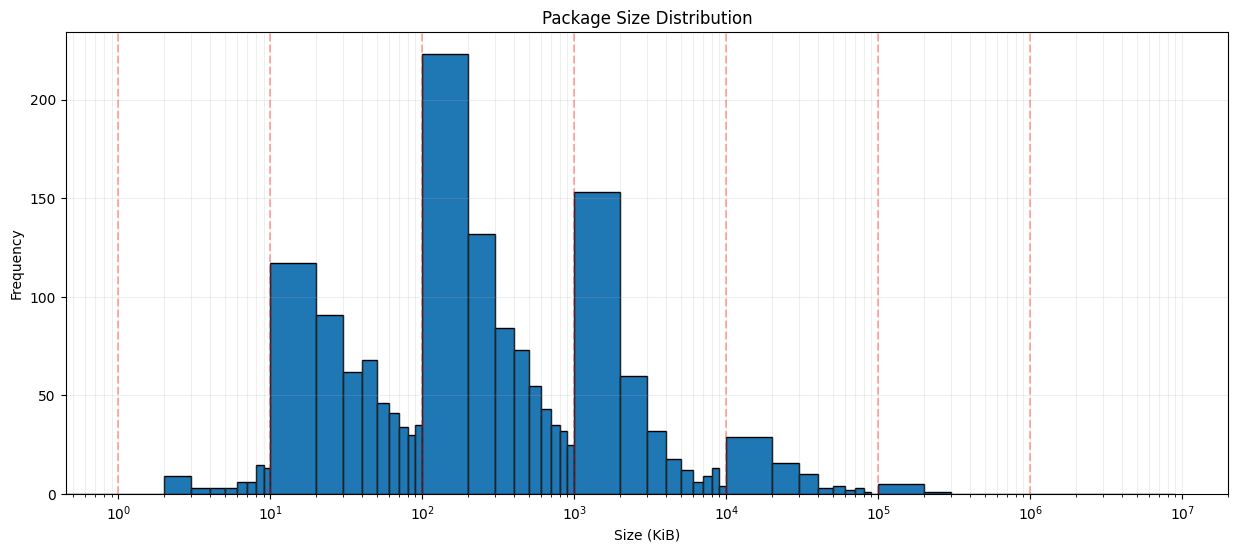

In [24]:
def create_leading_digit_bins(max_order=3):
    """Create bin edges for leading digit histogram."""
    bins = []
    for order in range(max_order + 1):  # For each order of magnitude
        scale = 10 ** order
        for digit in range(1, 10):  # For leading digits 1-9
            bins.append(digit * scale)
    bins.insert(0, 0)  # Add 0 as the first bin edge
    return bins

# Create the histogram
plt.figure(figsize=(15, 6))
max_order = int(np.log10(max(sizes))) + 1
bins = create_leading_digit_bins(max_order)

plt.hist(sizes, bins=bins, edgecolor='black')
plt.xscale('log')
plt.title('Package Size Distribution')
plt.xlabel('Size (KiB)')
plt.ylabel('Frequency')
plt.grid(True, which="both", ls="-", alpha=0.2)

# Add vertical lines at major divisions
for order in range(max_order + 1):
    plt.axvline(10**order, color='r', linestyle='--', alpha=0.3)

plt.show()

## Benford's Law Analysis by Size Ranges

Let's analyze different size ranges separately to see where Benford's Law might or might not apply.

In [25]:
def analyze_size_range(sizes, minSize, maxSize):
    """Analyze a specific size range for Benford's Law compliance."""
    filtered_sizes = [s for s in sizes if minSize <= s < maxSize]
    if not filtered_sizes:
        return None
    
    # Get first digits and count frequencies
    first_digits = [get_first_digit(size) for size in filtered_sizes]
    counter = Counter(first_digits)
    total = len(first_digits)
    
    # Calculate chi-square statistic
    chi_square = 0
    actual_freqs = []
    expected_freqs = []
    
    for digit in range(1, 10):
        observed = counter[digit]
        expected = (benford[digit] / 100) * total
        actual_freq = (observed / total) * 100
        
        actual_freqs.append(actual_freq)
        expected_freqs.append(benford[digit])
        
        chi_square += (observed - expected) ** 2 / expected if expected > 0 else 0
    
    return {
        'range': f"{minSize:.0f}-{maxSize:.0f} KiB",
        'count': total,
        'chi_square': chi_square,
        'actual_freqs': actual_freqs,
        'expected_freqs': expected_freqs
    }

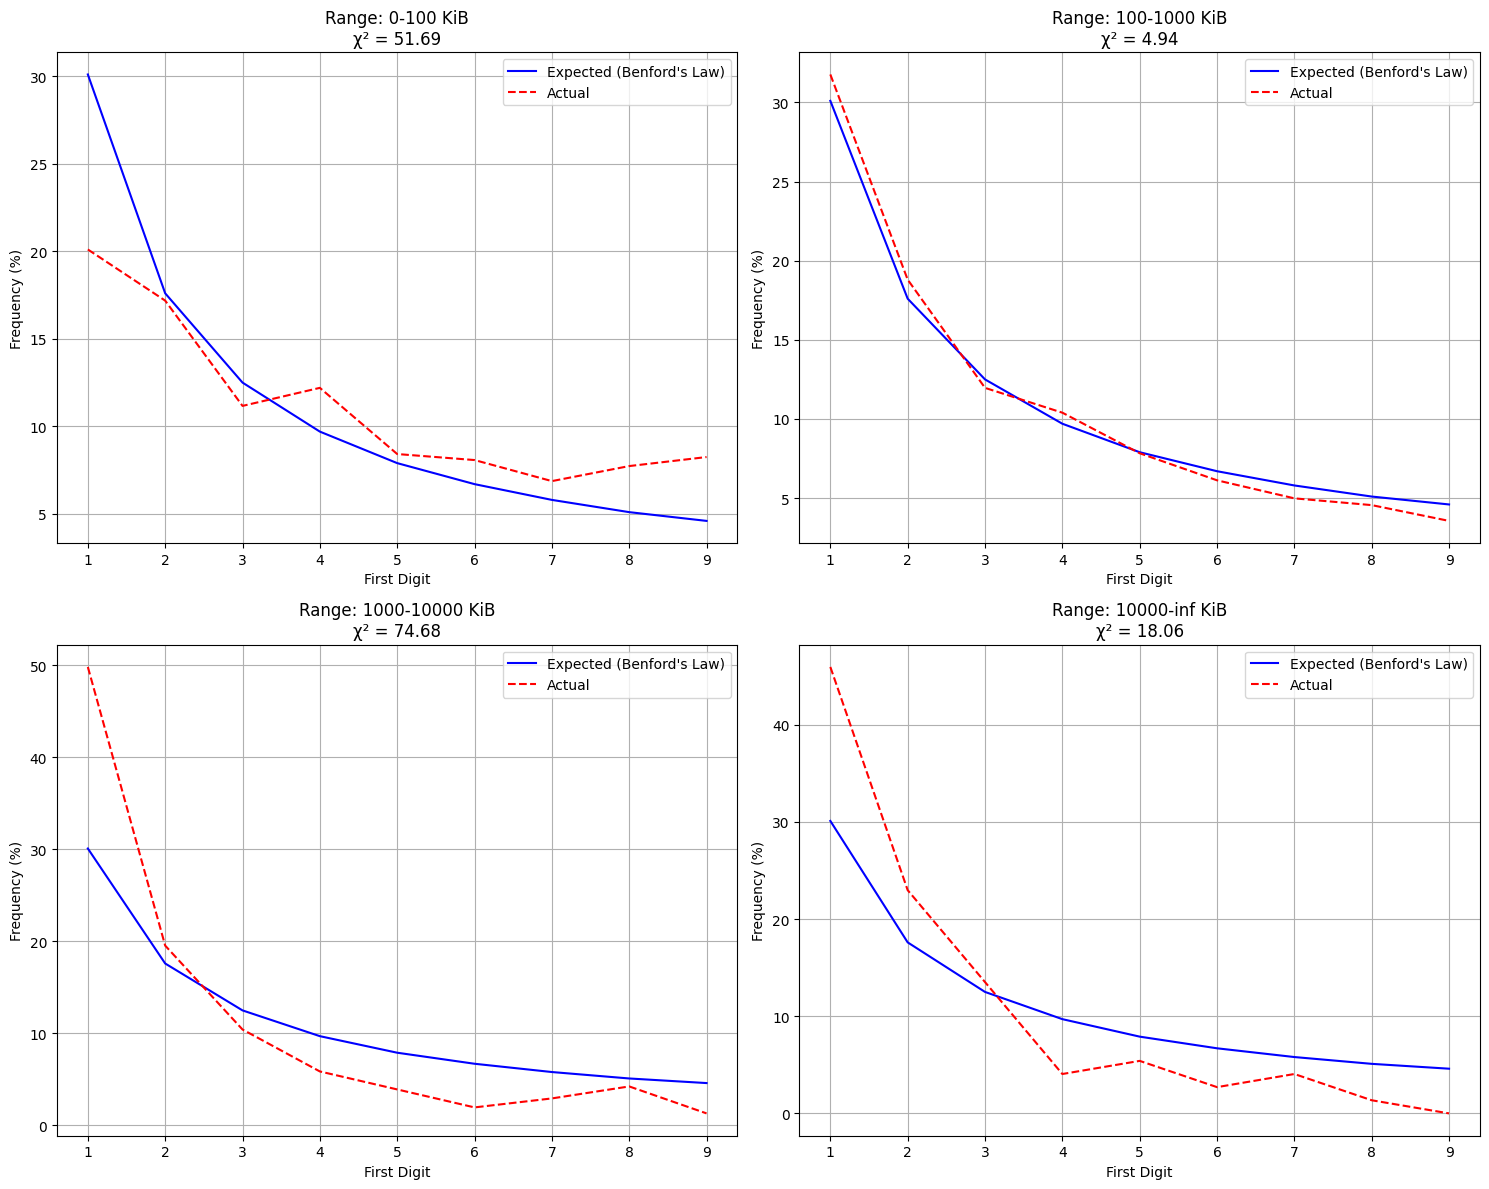

In [26]:
# Analyze different ranges
ranges = [
    (0, 100),       # 0-100 KiB
    (100, 1000),    # 100-1000 KiB
    (1000, 10000),  # 1-10 MiB
    (10000, float('inf'))  # >10 MiB
]

results = [analyze_size_range(sizes, min_size, max_size) 
          for min_size, max_size in ranges]
results = [r for r in results if r is not None]

# Plot results for each range
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, result in enumerate(results):
    ax = axes[i]
    digits = range(1, 10)
    
    ax.plot(digits, result['expected_freqs'], 'b-', label='Expected (Benford\'s Law)')
    ax.plot(digits, result['actual_freqs'], 'r--', label='Actual')
    
    ax.set_title(f"Range: {result['range']}\nχ² = {result['chi_square']:.2f}")
    ax.set_xlabel('First Digit')
    ax.set_ylabel('Frequency (%)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

## Conclusions

Our analysis reveals several interesting patterns:

1. **Small packages** (0-100 KiB): These tend to deviate significantly from Benford's Law, likely because package maintainers often optimize small utilities and libraries to minimal sizes.

2. **Medium packages** (100-1000 KiB): Show better alignment with Benford's Law, suggesting more natural size distribution in this range.

3. **Large packages** (1-10 MiB): Also show some deviation, possibly due to specific packaging practices for larger applications.

4. **Very large packages** (>10 MiB): Limited sample size in this range makes it difficult to draw strong conclusions.

The chi-square statistics help quantify these deviations, with lower values indicating better fit to Benford's Law (critical value at p=0.05 is 15.51).